<a href="https://colab.research.google.com/github/Cyborgkong/pytorch-crashcourse-for-beginners/blob/main/02_pytorch_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 02. Neural Network classification with PyTorch

Classification is a problem of predicting whether something is one thing or another (there can be multiple things as the options)

## 1. Make classification data and get it ready

In [38]:
import sklearn

In [39]:
from sklearn.datasets import make_circles
import torch

# Make 1000 samples
n_samples = 1000

# Create circles
X, y = make_circles(n_samples,
                    noise=0.03,
                    random_state=42)

# Convert data to tensors (assuming CPU for now as device agnostic code comes later)
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

In [40]:
len(X), len(y)

(1000, 1000)

In [42]:
print(f"First 5 samples of X:\n {X[:5]}")
print(f"First 5 samples of y:\n {y[:5]}")

First 5 samples of X:
 tensor([[ 0.7542,  0.2315],
        [-0.7562,  0.1533],
        [-0.8154,  0.1733],
        [-0.3937,  0.6929],
        [ 0.4422, -0.8967]])
First 5 samples of y:
 tensor([1., 1., 1., 1., 0.])


In [43]:
# Make a DataFrame of circle data
import pandas as pd
circles = pd.DataFrame({"X1": X[:, 0],
                        "X2": X[:, 1],
                        "label": y})
circles.head(10)

,X1,X2,label
0,0.754246,0.231481,1.0
1,-0.756159,0.153259,1.0
2,-0.815392,0.173282,1.0
3,-0.393731,0.692883,1.0
4,0.442208,-0.896723,0.0
5,-0.479646,0.676435,1.0
6,-0.013648,0.803349,1.0
7,0.771513,0.147760,1.0
8,-0.169322,-0.793456,1.0
9,-0.121486,1.021509,0.0


In [45]:
circles.label.value_counts()

,count
label,
1.0,500
0.0,500


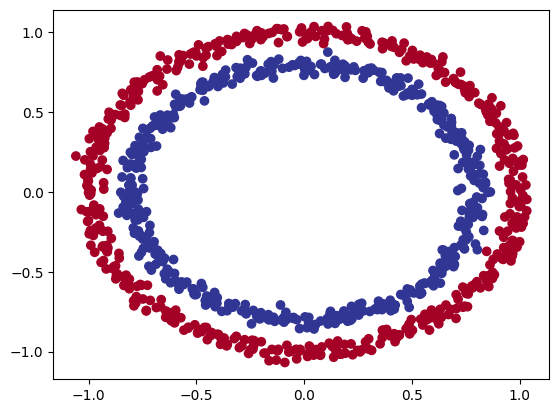

In [46]:
# Visualize, visualize, visualize
import matplotlib.pyplot as plt
plt.scatter(x=X[:, 0],
            y=X[:, 1],
            c=y,
            cmap=plt.cm.RdYlBu);

**Note:** The data we're working with is often referred to as a toy dataset, a dataset that is small enough to experiment on but still sizeable enough to practice the fundamentals.

### 1.1 Check input and output shape

In [47]:
X.shape, y.shape

(torch.Size([1000, 2]), torch.Size([1000]))

In [48]:
X

tensor([[ 0.7542,  0.2315],
        [-0.7562,  0.1533],
        [-0.8154,  0.1733],
        ...,
        [-0.1369, -0.8100],
        [ 0.6704, -0.7675],
        [ 0.2811,  0.9638]])

In [49]:
# View the first example of features and labels
X_sample = X[0]
y_sample = y[0]

print(f"Values for one sample of X: {X_sample.numpy()} and the same for y: {y_sample.numpy()}")
print(f"Shape for one sample of X: {X_sample.shape} and the same for y: {y_sample.shape}")

Values for one sample of X: [0.75424623 0.23148073] and the same for y: 1.0
Shape for one sample of X: torch.Size([2]) and the same for y: torch.Size([])


### 1.2 Turn data into tensors and create train and test splits

In [50]:
import torch
torch.__version__

'2.6.0+cu124'

In [51]:
type(X), X.dtype

(torch.Tensor, torch.float32)

In [57]:
# Turn data into tensors
# X = torch.from_numpy(X).type(torch.float) # This line is not needed as X is already a tensor
# y = torch.from_numpy(y).type(torch.float) # This line is not needed as y is already a tensor

X[:5], y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

In [58]:
type(X), X.dtype, y.dtype

(torch.Tensor, torch.float32, torch.float32)

In [59]:
# Split data into training and test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2, # 0.2 = 20% of data will be test & 80% will be train
                                                    random_state=42)

In [61]:
len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

## 2. Building a model

Let's build a model to classify our blue and red dots.

To do so, we want to:
1. Setup device agnostic code so our code will run on an accelerator (GPU) if there is one
2. Construct a model (by subclassing `nn.Module`)
3. Define a loss function and optimizer
4. Create training and test loop

In [62]:
# Import PyTorch and nn
import torch
from torch import nn

# Make device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

Now we've setup device agnostic code, let's create a model that:

1. Subclasses `nn.Module` (almost all models in Pytorch subclass `nn.Module`)
2. Create 2 `nn.Linear()` layers that are capable of handling the shapes of our data
3. Defines a `forward()` method that outlines the forward pass (or forward computation) of the model
4. instatiate an instance of our model class and send it to the target `device`

In [63]:
from sklearn import datasets
# 1. Construct a model that subclasses nn.Module
class CircleModelV0(nn.Module):
  def __init__(self):
    super().__init__()
    # 2. Create 2 nn.Linear layers capable of handling the shape of our data
    self.layer_1 = nn.Linear(in_features=2, out_features=5) # takes in 2 features and upscales to 5 features
    self.layer_2 = nn.Linear(in_features=5, out_features=1) # takes in 5 features from previous layer and outputs a single feature (same shape as y)

  # 3. Define a forward() method that outlines the forward pass of the model
  def forward(self, x):
    return self.layer_2(self.layer_1(x)) # x -> layer_1(output) -> layer_2 -> output

# 4. Instantiate an instance of our model class and send it to the target device
model_0 = CircleModelV0().to(device)
model_0

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [64]:
device

'cpu'

In [65]:
next(model_0.parameters()).device

device(type='cpu')

In [66]:
# Let's replicate the model above by using nn.Sequntial
model_0 = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1),
).to(device)

model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [67]:
model_0.state_dict()

OrderedDict([('0.weight',
              tensor([[ 0.0632, -0.3464],
                      [ 0.5730, -0.3257],
                      [-0.2110, -0.6720],
                      [-0.6127,  0.4914],
                      [ 0.1321,  0.4031]])),
             ('0.bias', tensor([ 0.3563, -0.0383,  0.2073, -0.1104, -0.6349])),
             ('1.weight',
              tensor([[-0.1137,  0.2692,  0.1441,  0.0641,  0.0956]])),
             ('1.bias', tensor([0.0255]))])

In [68]:
# Make predictions
with torch.inference_mode():
  untrained_preds = model_0(X_test.to(device))
print(f"Length of predictions: {len(untrained_preds)}, Shape: {untrained_preds.shape}")
print(f"Length of test samples: {len(X_test)}, Shape: {X_test.shape}")
print(f"\nFirst 10 predictions:\n {torch.round(untrained_preds[:10])}")
print(f"\nFirst 10 labels:\n {y_test[:10]}")

Length of predictions: 200, Shape: torch.Size([200, 1])
Length of test samples: 200, Shape: torch.Size([200, 2])

First 10 predictions:
 tensor([[-0.],
        [-0.],
        [-0.],
        [-0.],
        [0.],
        [0.],
        [-0.],
        [0.],
        [-0.],
        [-0.]])

First 10 labels:
 tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


In [69]:
X_test[:10], y_test[:10]

(tensor([[-0.3752,  0.6827],
         [ 0.0154,  0.9600],
         [-0.7028, -0.3147],
         [-0.2853,  0.9664],
         [ 0.4024, -0.7438],
         [ 0.6323, -0.5711],
         [ 0.8561,  0.5499],
         [ 1.0034,  0.1903],
         [-0.7489, -0.2951],
         [ 0.0538,  0.9739]]),
 tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.]))

## 2.1 Setup loss function and optimizer

Which loss function or optimizer should we use?

This is problem specific.

For example for regression we might want MAE or MSE (mean absolute error or mean squared error).and

For classification we might want binary cross entropy or categorical cross entropy (cross entropy is the most common).

As a reminder, the loss function  measures how *wrong* your models predictions are.

And for optimizers, two of the most common and useful are SGD and Adam, however PyTorch has many built in

* For the loss function we're going to use `torch.nn.BCEWithLogitsLoss()`

In [70]:
# Setup the loss function
# loss_fn = nn.BCELoss() # BCELoss = requires inputs to have gone through the sigmoid activation function prior to input to BCELoss
loss_fn = nn.BCEWithLogitsLoss() # BCEWithLogitsLoss = sigmoid activation function built-in

optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.1)

In [71]:
# Calculate accuracy - out of 100 examples, what percentage does our model get right?
def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = (correct / len(y_pred)) * 100
  return acc

## 3. Train model

To train our model, we're going to need to build a training loop with the following steps:

1. Forward pass
2. Calculate the loss
3. Optimizer zero grad
4. Loss backward (back propagation)
5. Optimizer step (gradient descent)

### 3.1 Going from raw logits -> prediction probabilities -> prediction labels

Our model outputs are going to be raw **logits**.

We can convert these **logits** into **prediction probabilities** by passing them to some kind of activation function (e.g. sigmoid for binary classification and softmax for multiclass classification).

Then we can convert our model's prediction probabilities to **prediction labels** by either rounding them or taking the `argmax()`.

In [72]:
# View the first 5 outputs of the forward pass on the test data
model_0.eval()
with torch.inference_mode():
  y_logits = model_0(X_test.to(device))[:5]
y_logits

tensor([[-0.1482],
        [-0.1339],
        [-0.1028],
        [-0.1615],
        [ 0.0290]])

In [73]:
y_test[:5]

tensor([1., 0., 1., 0., 1.])

In [74]:
# Use the sigmoid activation funtion on our model logits to turn them into prediction probabilities
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.4630],
        [0.4666],
        [0.4743],
        [0.4597],
        [0.5072]])

For our prediction probability values, we need to perform a range-style rounding on them:
* `y_pred_probs` >= 0.5, `y=1` (class 1)
* `y_pred_probs` < 0.5, `y=0` (class 0)

In [75]:
# Find the predicted labels
y_preds = torch.round(y_pred_probs)

# In full (logits -> pred probs -> pred lables)
y_pred_labels = torch.round(torch.sigmoid(model_0(X_test.to(device))[:5]))

# Check for equality
print(torch.eq(y_preds.squeeze(), y_pred_labels.squeeze()))

# Get rid of extra dimension
y_preds.squeeze()

tensor([True, True, True, True, True])


tensor([0., 0., 0., 0., 1.])

### 3.2 Building a training and testing loop

In [76]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set the number of epochs
epochs = 1000

# Put the data to target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Build training and evaluation loop
for epoch in range(epochs):
  ## Training
  model_0.train()

  # 1. Forward pass
  y_logits = model_0(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits)) # turn logits -> pred probs -> pred labels

  # 2. Calculate loss/ accuracy
  #loss = loss_fn(torch.sigmoid(y_logits), # nn.BCELoss expects prediction probabilities as input
  #               y_train)
  loss = loss_fn(y_logits, # nn.BCEWithLogitsLoss expects raw logits as input
                 y_train)
  acc = accuracy_fn(y_true=y_train,
                     y_pred=y_pred)

  # 3. Optimizer zero grad
  optimizer.zero_grad()

  # 4. Loss backward
  loss.backward()

  # 5. Optimizer step
  optimizer.step()

  ### Testing
  model_0.eval()
  with torch.inference_mode():
    # 1. Forward pass
    test_logits = model_0(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    # 2. Calculate the test loss/ acc
    test_loss = loss_fn(test_logits,
                        y_test)
    test_acc = accuracy_fn(y_true=y_test,
                           y_pred=test_pred)

    # Print out what's happening
    if epoch % 10 == 0:
      print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}%)")

Epoch: 0 | Loss: 0.69454, Accuracy: 47.62% | Test Loss: 0.69368, Test Acc: 46.50%)
Epoch: 10 | Loss: 0.69413, Accuracy: 48.38% | Test Loss: 0.69339, Test Acc: 46.00%)
Epoch: 20 | Loss: 0.69386, Accuracy: 48.50% | Test Loss: 0.69327, Test Acc: 48.00%)
Epoch: 30 | Loss: 0.69366, Accuracy: 48.38% | Test Loss: 0.69323, Test Acc: 47.00%)
Epoch: 40 | Loss: 0.69351, Accuracy: 48.75% | Test Loss: 0.69324, Test Acc: 47.50%)
Epoch: 50 | Loss: 0.69340, Accuracy: 49.00% | Test Loss: 0.69328, Test Acc: 44.50%)
Epoch: 60 | Loss: 0.69332, Accuracy: 49.88% | Test Loss: 0.69333, Test Acc: 45.00%)
Epoch: 70 | Loss: 0.69325, Accuracy: 49.62% | Test Loss: 0.69340, Test Acc: 44.50%)
Epoch: 80 | Loss: 0.69319, Accuracy: 50.00% | Test Loss: 0.69347, Test Acc: 43.50%)
Epoch: 90 | Loss: 0.69315, Accuracy: 48.75% | Test Loss: 0.69354, Test Acc: 48.00%)
Epoch: 100 | Loss: 0.69312, Accuracy: 47.88% | Test Loss: 0.69361, Test Acc: 49.50%)
Epoch: 110 | Loss: 0.69309, Accuracy: 49.00% | Test Loss: 0.69367, Test Acc:

## 4. Make predictions and evaluate the model

From the matrics it looks like our model isn't learning anything...

so to inspect it let's make some predictions and let's make them visual:

In other words, "Visualize, visualize, visualize!"

To do so, we're going to import a function called `plot_decision_boundary()`

In [77]:
import requests
from pathlib import Path

# Download helper functions from Learn PyTorch repo (if it's not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

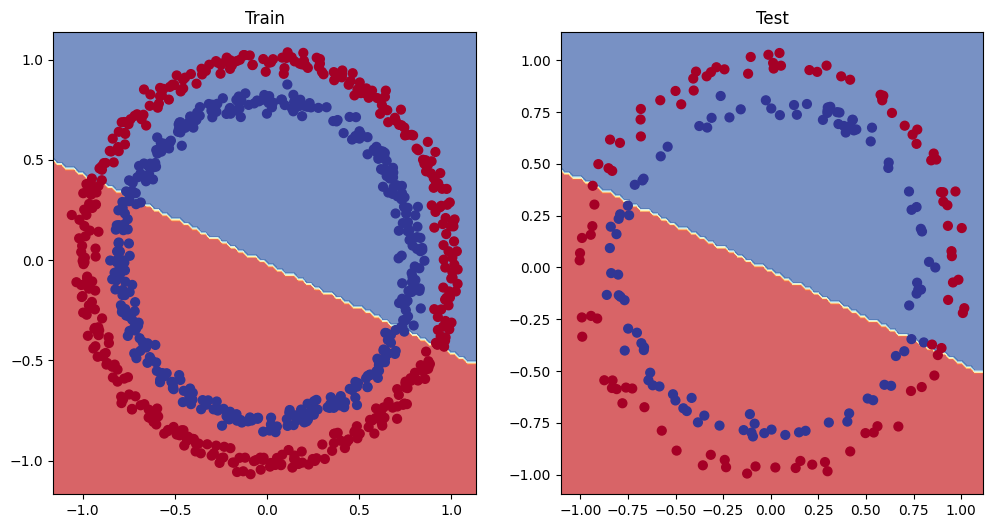

In [78]:
# Plot decision boundary of the model
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)

## 5. Improving a model (from a model perspective)

* Add more layers - give the model more chances to learn about patterns in the data
* Add more hidden units - go from 5 hidden units to 10 hidden units
* Fit for longer
* Changing the activation functions
* Change the learning rate
* Change the loss function

These options are all from our model's perspective because they deal directly with model, rather than the data.

And because these options are all values we (as machine learning engineers and scientists) can change, they are referred as **hyperparameters**.

Let's try and improve our model by:
* Adding more hidden units: 5 -> 10
* Increase the number of layers: 2 -> 3
* Increase the number of epochs 100 -> 1000

In [79]:
class CircleModelV1(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features=2, out_features=10)
    self.layer_2 = nn.Linear(in_features=10, out_features=10)
    self.layer_3 = nn.Linear(in_features=10, out_features=1)

  def forward(self, x):
    #z = self.layer_1(x)
    #z = self.layer_2(z)
    #z = self.layer_3(z)
    return self.layer_3(self.layer_2(self.layer_1(x))) # this way of writing operations leverages speed ups where possible behind the scenes

model_1 = CircleModelV1().to(device)
model_1

CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

In [80]:
# Create a loss function
loss_fn = nn.BCEWithLogitsLoss()

# Create an optimizer
optimizer = torch.optim.SGD(params=model_1.parameters(),
                            lr=0.001)

In [81]:
# Write a training and evaluating loop for model_1
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Train for longer
epochs = 1000

# Put data to target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
  ### Training
  model_1.train()

  # 1. Forward pass
  y_logits = model_1(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits)) # logits -> pred probs -> pred labels

  # 2. Calculate loss/acc
  loss = loss_fn(y_logits,
                 y_train)
  acc = accuracy_fn(y_true=y_train,
                    y_pred=y_pred)

  # 3. Optimizer zero_grad
  optimizer.zero_grad()

  # Loss backward
  loss.backward()

  # Optimizer step
  optimizer.step()

  ### Test
  model_1.eval()
  with torch.inference_mode():
    # 1. Forward pass
    test_logits = model_1(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    # 2. Calculate loss
    test_loss = loss_fn(test_logits,
                        y_test)
    test_acc = accuracy_fn(y_true=y_test,
                           y_pred=test_pred)

    if epoch % 100 == 0:
      print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Acc: : {test_acc:.2f}%)")

Epoch: 0 | Loss: 0.69396, Accuracy: 50.88% | Test Loss: 0.69261, Test Acc: : 51.00%)
Epoch: 100 | Loss: 0.69392, Accuracy: 50.50% | Test Loss: 0.69261, Test Acc: : 51.00%)
Epoch: 200 | Loss: 0.69389, Accuracy: 50.62% | Test Loss: 0.69262, Test Acc: : 50.50%)
Epoch: 300 | Loss: 0.69386, Accuracy: 50.62% | Test Loss: 0.69263, Test Acc: : 50.50%)
Epoch: 400 | Loss: 0.69383, Accuracy: 50.62% | Test Loss: 0.69263, Test Acc: : 51.00%)
Epoch: 500 | Loss: 0.69381, Accuracy: 50.75% | Test Loss: 0.69264, Test Acc: : 50.50%)
Epoch: 600 | Loss: 0.69378, Accuracy: 50.62% | Test Loss: 0.69265, Test Acc: : 51.00%)
Epoch: 700 | Loss: 0.69376, Accuracy: 50.25% | Test Loss: 0.69266, Test Acc: : 51.00%)
Epoch: 800 | Loss: 0.69373, Accuracy: 50.00% | Test Loss: 0.69267, Test Acc: : 50.50%)
Epoch: 900 | Loss: 0.69371, Accuracy: 49.88% | Test Loss: 0.69268, Test Acc: : 50.50%)


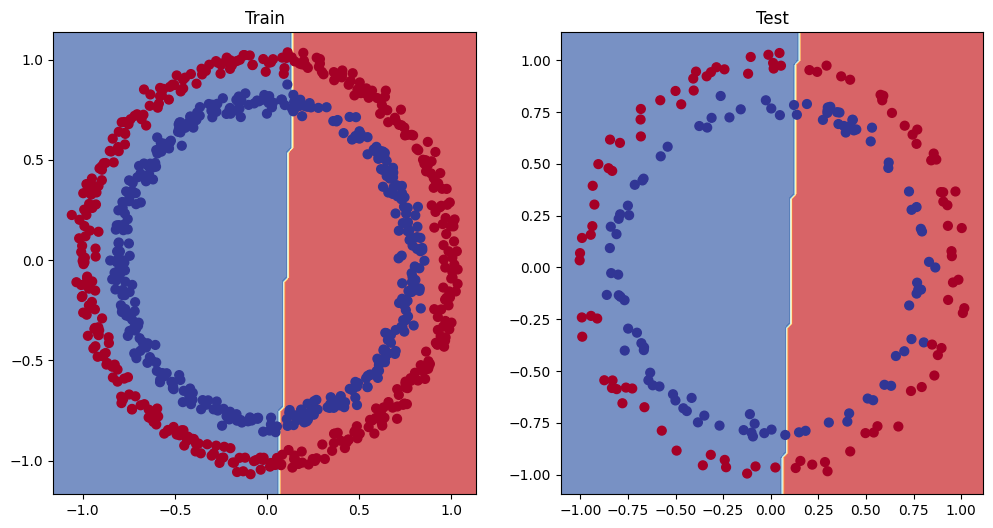

In [82]:
# Plot decision boundary of the model
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_1, X_test, y_test)

### 5.1 Preparing data to see if our model can fit a straight line

One way to troubleshoot to a larger problem is to test out a smaller problem

In [83]:
# Create some data (same as notebook 01)
weight = 0.7
bias = 0.3

start = 0
end = 1
step = 0.01
X_regression = torch.arange(start, end, step).unsqueeze(dim=1)
y_regression = weight * X_regression + bias

print(len(X_regression))
X_regression[:5], y_regression[:5]

100


(tensor([[0.0000],
         [0.0100],
         [0.0200],
         [0.0300],
         [0.0400]]),
 tensor([[0.3000],
         [0.3070],
         [0.3140],
         [0.3210],
         [0.3280]]))

In [84]:
train_split = int(0.8 * len(X_regression))
X_train_reg, y_train_reg = X_regression[:train_split], y_regression[:train_split]
X_test_reg, y_test_reg = X_regression[train_split:], y_regression[train_split:]

len(X_train_reg), len(y_train_reg), len(X_test_reg), len(y_test_reg)

(80, 80, 20, 20)

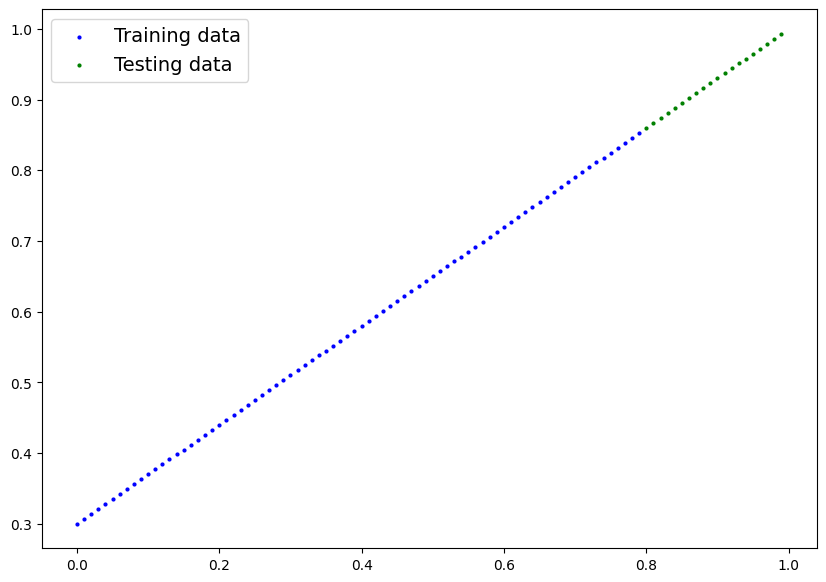

In [85]:
plot_predictions(train_data=X_train_reg,
                 train_labels=y_train_reg,
                 test_data=X_test_reg,
                 test_labels=y_test_reg);

### 5.2 Adjusting `model_1` to fit a straight line

In [86]:
# Same architecture as model_1 (but using nn.Sequential)
model_2 = nn.Sequential(
    nn.Linear(in_features=1, out_features=100),
    nn.Linear(in_features=100, out_features=100),
    nn.Linear(in_features=100, out_features=1)
).to(device)

model_2

Sequential(
  (0): Linear(in_features=1, out_features=100, bias=True)
  (1): Linear(in_features=100, out_features=100, bias=True)
  (2): Linear(in_features=100, out_features=1, bias=True)
)

In [87]:
# Loss and optimizer
loss_fn = nn.L1Loss()
optimizer = torch.optim.SGD(params=model_2.parameters(),
                            lr=0.0002)

In [88]:
# Train the model
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set the number of epochs
epochs = 1000

# Put the data on the target device
X_train_reg, y_train_reg = X_train_reg.to(device), y_train_reg.to(device)
X_test_reg, y_test_reg = X_test_reg.to(device), y_test_reg.to(device)

# Training
for epoch in range(epochs):
    y_pred = model_2(X_train_reg)
    loss = loss_fn(y_pred, y_train_reg)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    ### Testing
    model_2.eval()
    with torch.inference_mode():
      test_pred = model_2(X_test_reg)
      test_loss = loss_fn(test_pred, y_test_reg)

    # Print out what's happening
    if epoch % 100 == 0:
      print(f"Epoch: {epoch} | Loss: {loss:.5f} | Test Loss: {test_loss:.5f}")

Epoch: 0 | Loss: 0.29054 | Test Loss: 0.52611
Epoch: 100 | Loss: 0.06505 | Test Loss: 0.16041
Epoch: 200 | Loss: 0.05063 | Test Loss: 0.11656
Epoch: 300 | Loss: 0.03646 | Test Loss: 0.08385
Epoch: 400 | Loss: 0.02218 | Test Loss: 0.05094
Epoch: 500 | Loss: 0.00777 | Test Loss: 0.01761
Epoch: 600 | Loss: 0.00366 | Test Loss: 0.00409
Epoch: 700 | Loss: 0.00358 | Test Loss: 0.00420
Epoch: 800 | Loss: 0.00350 | Test Loss: 0.00432
Epoch: 900 | Loss: 0.00342 | Test Loss: 0.00444


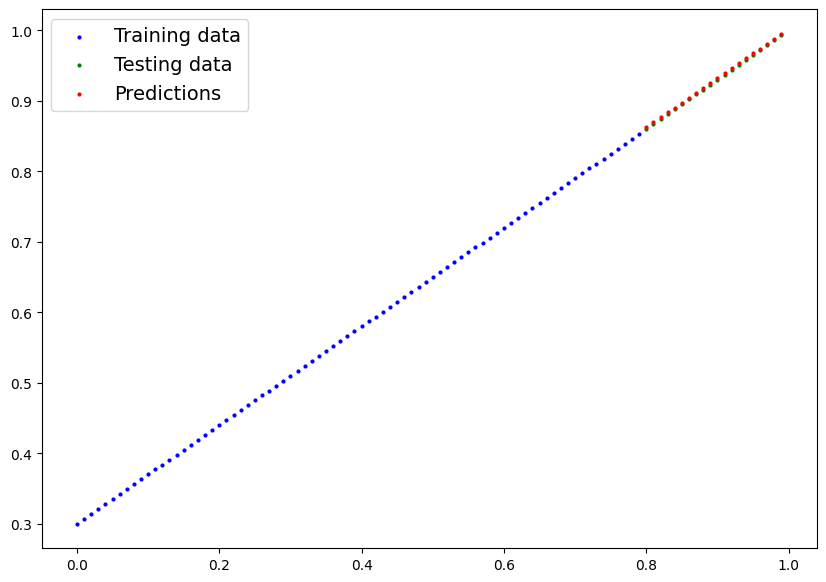

In [89]:
# Turn on evaluation mode
model_2.eval()

# Make predictions
with torch.inference_mode():
  y_preds = model_2(X_test_reg)

# Plot data and predictions
plot_predictions(train_data=X_train_reg.cpu(),
                 train_labels=y_train_reg.cpu(),
                 test_data=X_test_reg.cpu(),
                 test_labels=y_test_reg.cpu(),
                 predictions=y_preds.cpu())

## 6. The missing piece: non-linearity

"What patterns could you draw if you were given an infinite amount of straight and non-straight lines?"

Or in machine learning terms, an infinite (but really it is finite) of linear and non-linear functions

### 6.1 Recreating non-linear data (red and blue circles)

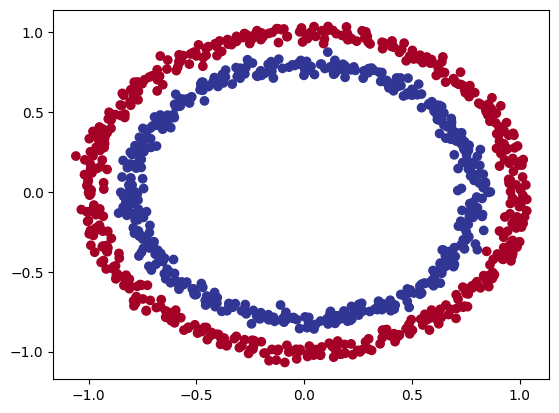

In [90]:
# Make and plot data
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles

n_samples = 1000

X, y = make_circles(n_samples,
                    noise=0.03,
                    random_state=42)

plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdYlBu);

In [91]:
# Convert data to tensors and then to train and test splits
import torch
from sklearn.model_selection import train_test_split

# Turn data into tensors
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42)

X_train[:5], y_train[:5]

(tensor([[ 0.6579, -0.4651],
         [ 0.6319, -0.7347],
         [-1.0086, -0.1240],
         [-0.9666, -0.2256],
         [-0.1666,  0.7994]]),
 tensor([1., 0., 0., 0., 1.]))

### 6.2 Building a model with non-linearity

* Linear = straight linese
* Non-linear = non-straight lines

Artificial neural networks are a large combination of linear (straight) and non-straight (non-linear) functions which are potentially able to find patterns in data

In [92]:
# Build a model with non-linear activation functions
from torch import nn
class CircleModelV2(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features=2, out_features=10)
    self.layer_2 = nn.Linear(in_features=10, out_features=10)
    self.layer_3 = nn.Linear(in_features=10, out_features=1)
    self.relu = nn.ReLU() # relu is a non-linear activation function

  def forward(self, x):
    # Where should we put our non-linear activation functions?
    return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))

model_3 = CircleModelV2().to(device)
model_3

CircleModelV2(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

In [93]:
# Setup loss and optimizer
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params=model_3.parameters(),
                            lr=0.1)

### Train a model with non-linearity

In [94]:
# Random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Put the data to target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Loop through data
epochs = 3000

for epoch in range(epochs):
  ### Training
  model_3.train()

  # 1. Forward pass
  y_logits = model_3(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits)) # Logits -> prediction probabilities -> prediction labels

  # 2. Calculate loss
  loss = loss_fn(y_logits,
                 y_train)
  acc = accuracy_fn(y_true=y_train,
                    y_pred=y_pred)

  # 3. Optimizer zero grad
  optimizer.zero_grad()

  # 4. Loss backward
  loss.backward()

  # 5. Optimizer step
  optimizer.step()

  # Testing
  model_3.eval()
  with torch.inference_mode():
    test_logits = model_3(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    test_loss = loss_fn(test_logits,
                        y_test)
    test_acc = accuracy_fn(y_true=y_test,
                           y_pred=test_pred)

    # Print out what's happening
    if epoch % 100 == 0:
      print(f"Epoch: {epoch} | Loss: {loss:.4f}, Accuracy: {acc:.2f}% | Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.6929, Accuracy: 50.00% | Test Loss: 0.6932, Test Acc: 50.00%
Epoch: 100 | Loss: 0.6912, Accuracy: 52.88% | Test Loss: 0.6910, Test Acc: 52.50%
Epoch: 200 | Loss: 0.6898, Accuracy: 53.37% | Test Loss: 0.6894, Test Acc: 55.00%
Epoch: 300 | Loss: 0.6879, Accuracy: 53.00% | Test Loss: 0.6872, Test Acc: 56.00%
Epoch: 400 | Loss: 0.6852, Accuracy: 52.75% | Test Loss: 0.6841, Test Acc: 56.50%
Epoch: 500 | Loss: 0.6810, Accuracy: 52.75% | Test Loss: 0.6794, Test Acc: 56.50%
Epoch: 600 | Loss: 0.6751, Accuracy: 54.50% | Test Loss: 0.6729, Test Acc: 56.00%
Epoch: 700 | Loss: 0.6666, Accuracy: 58.38% | Test Loss: 0.6632, Test Acc: 59.00%
Epoch: 800 | Loss: 0.6516, Accuracy: 64.00% | Test Loss: 0.6476, Test Acc: 67.50%
Epoch: 900 | Loss: 0.6236, Accuracy: 74.00% | Test Loss: 0.6215, Test Acc: 79.00%
Epoch: 1000 | Loss: 0.5682, Accuracy: 87.75% | Test Loss: 0.5738, Test Acc: 86.50%
Epoch: 1100 | Loss: 0.4815, Accuracy: 93.50% | Test Loss: 0.4993, Test Acc: 90.50%
Epoch: 1200 | Lo

### 6.4 Evaluating a model trained with non-linear activation functions

In [95]:
# Make predictions
model_3.eval()
with torch.inference_mode():
  y_preds = torch.round(torch.sigmoid(model_3(X_test))).squeeze()
y_preds[:10], y_test[:10]

(tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.]),
 tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.]))

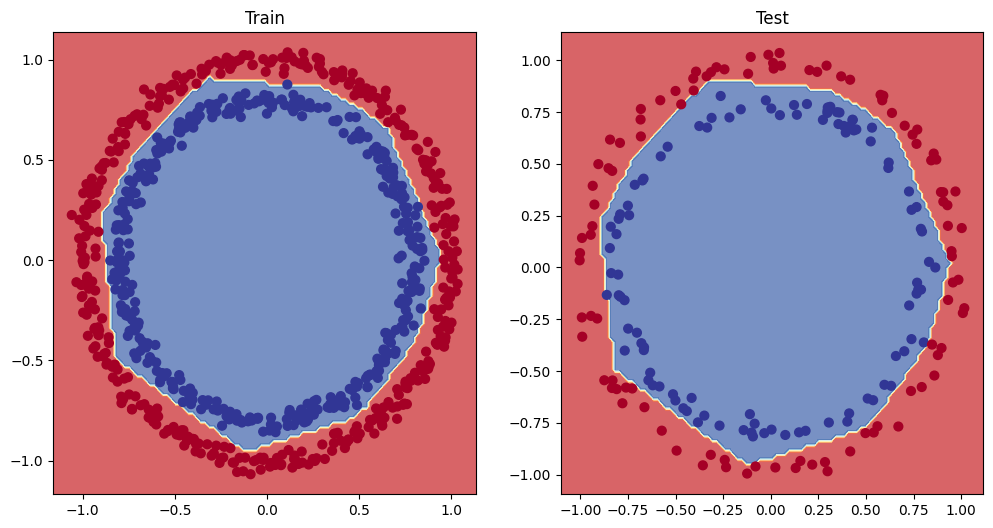

In [96]:
# Plot decision boundaries
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_3, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_3, X_test, y_test)

### 7. Replicating non-linear activation functions

Neural networks, rather than us telling the model what to learn, we give it the tools to discover patterns in data and it tries to figure out the pattern on its own.

And these tools are linear & non-linear functions

In [97]:
# Create a tensor
A = torch.arange(-10, 10, 1, dtype=torch.float32)
A

tensor([-10.,  -9.,  -8.,  -7.,  -6.,  -5.,  -4.,  -3.,  -2.,  -1.,   0.,   1.,
          2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.])

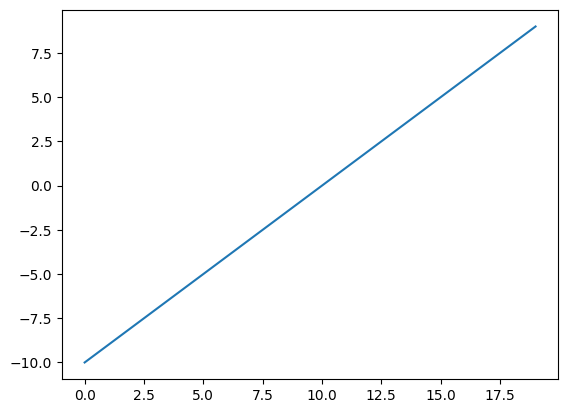

In [98]:
# Visualize the tensor
plt.plot(A);

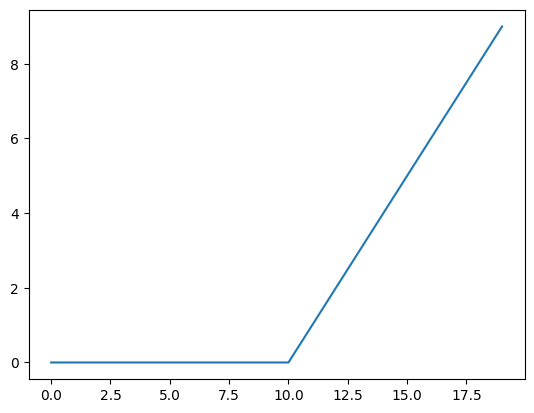

In [99]:
plt.plot(torch.relu(A));

In [100]:
def relu(x: torch.Tensor) -> torch.Tensor:
  return torch.max(torch.tensor(0), x) # inputs must be tensors

relu(A)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 3., 4., 5., 6., 7.,
        8., 9.])

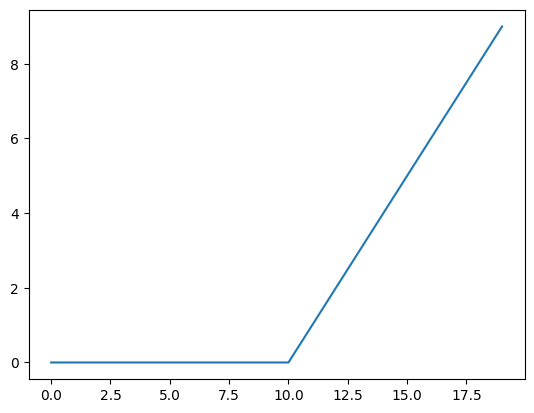

In [101]:
# Plot ReLU activation function
plt.plot(relu(A));

In [102]:
# Now let's do the same for sigmoid
def sigmoid(x):
  return 1 / (1 + torch.exp(-x))

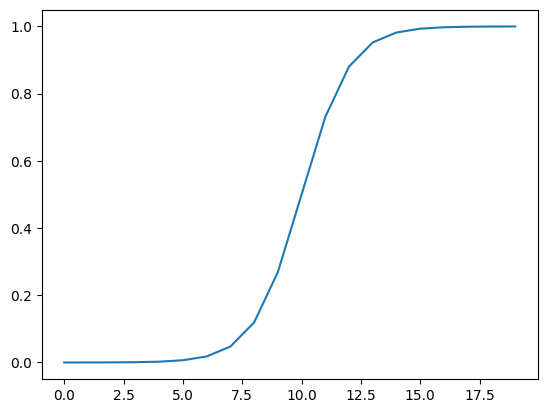

In [103]:
plt.plot(torch.sigmoid(A));

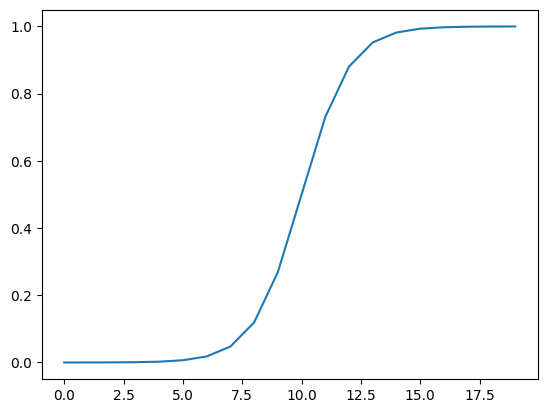

In [104]:
plt.plot(sigmoid(A));

## 8. Putting it all together with a multi-class classification problem

* Binary classification = one thing or another (cat vs. dog, spam vs. not spam, fraud or not fraud)
* Multi-class classification - more than one thing or another (cat vs. dog vs. chicken)

### 8.1 Creating a toy multi-class dataset

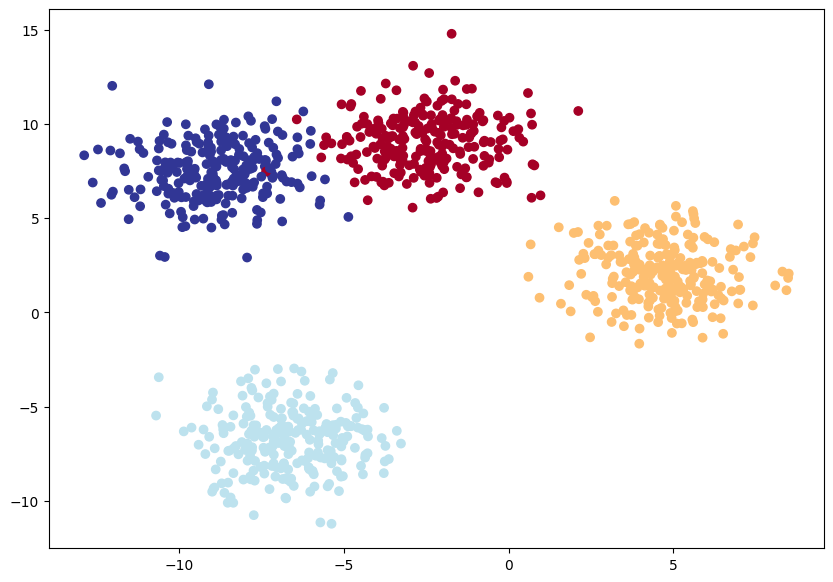

In [105]:
# Import dependencies
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

# Set the hyperparameters for data creation
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

# 1. Create multi-class data
X_blob, y_blob = make_blobs(n_samples=1000,
                            n_features=NUM_FEATURES,
                            centers=NUM_CLASSES,
                            cluster_std=1.5, # give the clusters a little shake up
                            random_state=RANDOM_SEED)

# 2. Turn data into tensors
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.float)

# 3. Split into train and test
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob,
                                                                        y_blob,
                                                                        test_size=0.2,
                                                                        random_state=RANDOM_SEED)

# 4. Plot data (visualize, visualize, visualize)
plt.figure(figsize=(10, 7))
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob, cmap=plt.cm.RdYlBu);

### 8.2 Building a multi-class classification model in PyTorch

In [106]:
# Create device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [107]:
# Build a multi-class classification model
class BlobModel(nn.Module):
  def __init__(self, input_features, output_features, hidden_units=8):
    '''Initialize multi-class classification model.

    Args:
      input_features (int): Number of input features to the model.
      output_features (int): Number of output features of the model
        which should equal the number of target classes or labels.
      hidden_units (int): Number of hidden units between layers, default 8.
      '''
    super().__init__()
    self.linear_layer_stack = nn.Sequential(
        nn.Linear(in_features=input_features, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=hidden_units)
    )
    self.output_layer = nn.Linear(in_features=hidden_units, out_features=output_features)


  def forward(self, x):
    return self.output_layer(self.linear_layer_stack(x))

# Create an instance of BlobModel and send it to the target device
model_4 = BlobModel(input_features=2,
                    output_features=4,
                    hidden_units=8).to(device)
model_4

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=8, bias=True)
  )
  (output_layer): Linear(in_features=8, out_features=4, bias=True)
)

In [108]:
X_blob_train.shape, y_blob_train[:5]

(torch.Size([800, 2]), tensor([1., 0., 2., 2., 0.]))

In [109]:
torch.unique(y_blob_train)

tensor([0., 1., 2., 3.])

### 8.3 Create a loss function and an optimizer for a multi-class classification model

In [110]:
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_4.parameters(),
                      lr=0.1)

### 8.4 Getting prediction probabilities for a multi-class Pytorch model

In order to evaluate and train and test our model, we need to convert our model's outputs (logits) to prediction probabilities and then to prediction labels.

Logits (raw output of the model) -> Pred probs (use `torch.softmax`) -> Pred labels (Take the argmax of the prediction probabilities)

In [111]:
# Let's get some raw outputs of our model (logits)
model_4.eval()
with torch.inference_mode():
  y_logits = model_4(X_blob_test.to(device))

y_logits[:10]

tensor([[ 0.1454, -0.0255, -0.1640,  0.0183],
        [ 0.0354, -0.3319, -0.0684,  0.0288],
        [-0.2355, -0.1569,  0.2998,  0.2376],
        [-0.0279, -0.0526, -0.0112,  0.1172],
        [ 0.2830, -0.4740, -0.2152, -0.1381],
        [ 0.0743, -0.3564, -0.1297, -0.0024],
        [-0.2586, -0.1328,  0.2595,  0.2130],
        [ 0.1729, -0.4107, -0.1479, -0.0636],
        [-0.2273, -0.1640,  0.2897,  0.2337],
        [ 0.1969, -0.4241, -0.1553, -0.0789]])

In [112]:
y_blob_test[:10]

tensor([1., 3., 2., 1., 0., 3., 2., 0., 2., 0.])

In [113]:
# Convert our model's logit output to prediction probabilities
y_pred_probs = torch.softmax(y_logits, dim=1)
print(y_logits[:5])
print(y_pred_probs[:5])

tensor([[ 0.1454, -0.0255, -0.1640,  0.0183],
        [ 0.0354, -0.3319, -0.0684,  0.0288],
        [-0.2355, -0.1569,  0.2998,  0.2376],
        [-0.0279, -0.0526, -0.0112,  0.1172],
        [ 0.2830, -0.4740, -0.2152, -0.1381]])
tensor([[0.2892, 0.2438, 0.2123, 0.2547],
        [0.2788, 0.1931, 0.2513, 0.2769],
        [0.1854, 0.2005, 0.3166, 0.2975],
        [0.2410, 0.2352, 0.2451, 0.2787],
        [0.3659, 0.1716, 0.2223, 0.2401]])


In [119]:
# Convert our model's prediction probabilities to prediction labels
y_preds = torch.argmax(y_pred_probs, dim=1)
y_preds

tensor([0, 0, 2, 3, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 3, 0, 0, 2, 2,
        2, 2, 0, 0, 0, 0, 3, 0, 3, 0, 0, 2, 3, 0, 0, 2, 0, 3, 0, 2, 0, 0, 3, 0,
        0, 0, 3, 0, 3, 3, 0, 2, 3, 3, 0, 2, 2, 0, 3, 2, 2, 0, 0, 0, 3, 0, 0, 0,
        0, 0, 2, 0, 3, 0, 0, 3, 0, 2, 0, 2, 0, 0, 2, 3, 0, 2, 0, 3, 0, 0, 0, 0,
        3, 0, 0, 2, 0, 0, 0, 0, 2, 0, 3, 0, 0, 2, 3, 3, 0, 2, 2, 0, 0, 0, 3, 2,
        2, 3, 0, 3, 2, 0, 0, 0, 2, 0, 3, 2, 0, 2, 0, 0, 0, 0, 0, 3, 0, 0, 2, 2,
        2, 2, 0, 0, 0, 2, 2, 0, 0, 2, 0, 0, 0, 0, 2, 0, 2, 0, 0, 2, 0, 3, 2, 0,
        2, 2, 2, 0, 0, 3, 0, 0, 3, 3, 3, 0, 0, 2, 2, 0, 2, 2, 0, 0, 2, 2, 0, 0,
        3, 0, 2, 0, 0, 3, 2, 0])

In [120]:
y_blob_test

tensor([1., 3., 2., 1., 0., 3., 2., 0., 2., 0., 0., 1., 0., 0., 0., 3., 3., 2.,
        3., 3., 3., 0., 1., 2., 2., 2., 3., 0., 1., 0., 3., 1., 1., 3., 1., 2.,
        1., 3., 0., 2., 0., 3., 3., 2., 0., 3., 1., 1., 0., 3., 1., 0., 1., 1.,
        3., 2., 1., 1., 3., 2., 2., 0., 3., 2., 2., 0., 0., 3., 3., 0., 0., 3.,
        3., 3., 2., 3., 3., 3., 3., 1., 0., 2., 3., 2., 3., 3., 2., 3., 3., 2.,
        3., 3., 1., 3., 3., 3., 1., 0., 3., 2., 0., 0., 3., 0., 2., 3., 1., 0.,
        3., 2., 1., 1., 0., 2., 2., 3., 0., 0., 1., 2., 2., 3., 0., 1., 2., 0.,
        0., 0., 2., 3., 1., 2., 3., 2., 0., 3., 0., 0., 1., 1., 1., 0., 2., 2.,
        2., 2., 0., 3., 3., 2., 2., 1., 3., 2., 0., 0., 3., 3., 2., 1., 2., 0.,
        3., 2., 0., 3., 2., 0., 2., 2., 2., 0., 3., 1., 1., 1., 1., 1., 3., 1.,
        0., 2., 2., 1., 2., 2., 0., 1., 2., 2., 0., 0., 1., 3., 2., 0., 3., 1.,
        2., 1.])